In [1]:
#yahoo finance as data source
#pip install yfinance
import yfinance as yf

In [2]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'GAIL.NS'

In [3]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-12,121.200027,124.000031,120.575027,122.975029,99.832718,28524420
2017-12-13,123.462532,125.700027,121.600029,122.950027,99.812416,22113702
2017-12-14,123.500031,124.275032,120.350029,121.775032,98.858543,12564112
2017-12-15,123.200027,124.625031,121.100029,121.412529,98.564262,13527340
2017-12-18,121.975029,126.112534,118.962532,124.000031,100.664833,25651817


In [5]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-06,93.500000,93.500000,92.199997,93.000000,93.000000,9031442
2022-12-07,92.800003,94.050003,92.800003,93.250000,93.250000,11134858
2022-12-08,93.250000,93.449997,92.449997,92.550003,92.550003,10614975
2022-12-09,93.050003,93.599998,90.300003,90.849998,90.849998,15835417
2022-12-12,91.099998,93.000000,90.199997,92.550003,92.550003,8164739


<AxesSubplot:xlabel='Date'>

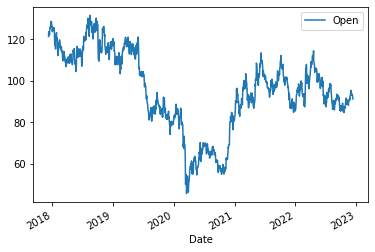

In [7]:
opn = data[['Open']]
opn.plot()

In [8]:
import matplotlib.pyplot as plt


In [9]:
ds = opn.values
ds

array([[121.20002747],
       [123.46253204],
       [123.50003052],
       ...,
       [ 93.25      ],
       [ 93.05000305],
       [ 91.09999847]])

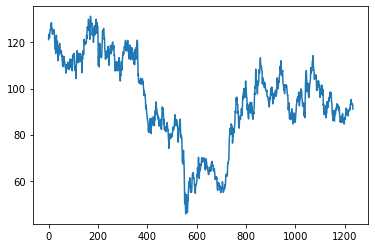

In [10]:
plt.plot(ds)

In [11]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [12]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [30]:
len(ds_scaled), len(ds)

(1235, 1235)

In [31]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size


In [33]:
train_size,test_size

(864, 371)

In [34]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]


In [35]:
len(ds_train),len(ds_test)

(864, 371)

In [36]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [37]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)


In [95]:
X_train.shape,y_train.shape

((763, 100, 1), (763,))

In [94]:
X_test.shape, y_test.shape

((270, 100, 1), (270,))

In [96]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [97]:
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [42]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [43]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)


Epoch 1/100
12/12 [==============================] - 13s 363ms/step - loss: 0.0828 - val_loss: 0.0172
Epoch 2/100
12/12 [==============================] - 3s 228ms/step - loss: 0.0178 - val_loss: 0.0143
Epoch 3/100
12/12 [==============================] - 2s 158ms/step - loss: 0.0089 - val_loss: 0.0032
Epoch 4/100
12/12 [==============================] - 2s 182ms/step - loss: 0.0059 - val_loss: 0.0030
Epoch 5/100
12/12 [==============================] - 2s 182ms/step - loss: 0.0049 - val_loss: 0.0032
Epoch 6/100
12/12 [==============================] - 2s 168ms/step - loss: 0.0044 - val_loss: 0.0031
Epoch 7/100
12/12 [==============================] - 3s 233ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 8/100
12/12 [==============================] - 2s 181ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 9/100
12/12 [==============================] - 2s 155ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 10/100
12/12 [==============================] - 2s 158ms/step - loss: 0.0041 - val_l

12/12 [==============================] - 3s 252ms/step - loss: 0.0012 - val_loss: 8.8582e-04
Epoch 82/100
12/12 [==============================] - 2s 144ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 83/100
12/12 [==============================] - 2s 162ms/step - loss: 0.0013 - val_loss: 8.3771e-04
Epoch 84/100
12/12 [==============================] - 3s 216ms/step - loss: 0.0011 - val_loss: 8.1053e-04
Epoch 85/100
12/12 [==============================] - 3s 248ms/step - loss: 0.0012 - val_loss: 8.0091e-04
Epoch 86/100
12/12 [==============================] - 3s 259ms/step - loss: 0.0011 - val_loss: 7.9740e-04
Epoch 87/100
12/12 [==============================] - 2s 201ms/step - loss: 0.0012 - val_loss: 8.8518e-04
Epoch 88/100
12/12 [==============================] - 3s 262ms/step - loss: 0.0011 - val_loss: 8.0428e-04
Epoch 89/100
12/12 [==============================] - 4s 312ms/step - loss: 0.0011 - val_loss: 8.4739e-04
Epoch 90/100
12/12 [==============================] - 3s 290ms/

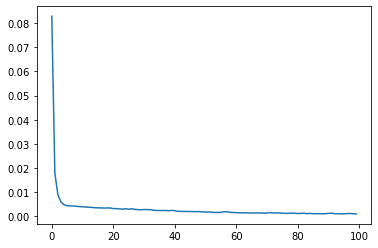

In [44]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [45]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 31ms/step


In [46]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

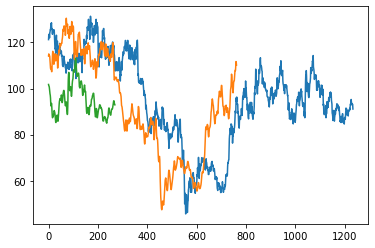

In [48]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)


In [85]:
len(ds_test)

371

In [86]:
#Getting the last 100 days records
fut_inp = ds_test[270:]


In [87]:
fut_inp = fut_inp.reshape(1,-1)

In [88]:
tmp_inp = list(fut_inp)

In [80]:
fut_inp.shape

(1, 100, 1)

In [89]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [90]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)


[[0.5451264977455139], [0.542694091796875], [0.5432618856430054], [0.5451488494873047], [0.547528862953186], [0.5500460863113403], [0.5525090098381042], [0.5547845363616943], [0.5567786693572998], [0.5584394335746765], [0.5597562193870544], [0.5607528686523438], [0.5614791512489319], [0.5619993805885315], [0.5623839497566223], [0.5627005696296692], [0.5630089044570923], [0.5633560419082642], [0.5637756586074829], [0.5642873644828796], [0.5648975372314453], [0.5656027793884277], [0.5663911700248718], [0.5672463774681091], [0.5681489706039429], [0.569080114364624], [0.5700224041938782], [0.5709616541862488], [0.5718868970870972], [0.5727912783622742]]


In [91]:
len(ds_scaled)

1235

In [92]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

ValueError: x and y must have same first dimension, but have shapes (100,) and (103, 1)

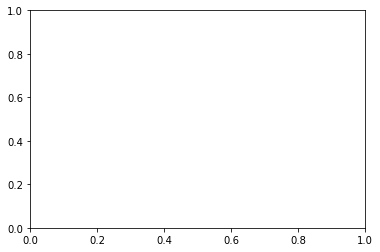

In [98]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1132:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))


In [69]:
ds_new = ds_scaled.tolist()

In [70]:
len(ds_new)

1235

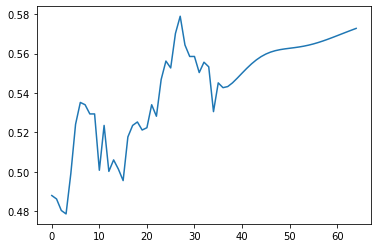

In [71]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [73]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()


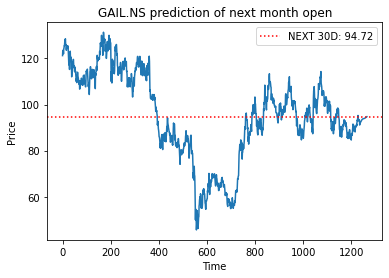

In [74]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()
